In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('/kaggle/input/marketing-campaign-veriseti-eksikveriyok/hazir_marketing_campaing.xlsx')
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,TotalSpent,TotalAcceptedCmp,Children,Customer_Age,Customer_Since_Days
0,1957,2,4,58138,0,0,58,635,88,546,...,0,0,0,0,1,1617,0,0,68,4665
1,1954,2,4,46344,1,1,38,11,1,6,...,0,0,0,0,0,27,0,2,71,4115
2,1965,2,5,71613,0,0,26,426,49,127,...,0,0,0,0,0,776,0,0,60,4314
3,1984,2,5,26646,1,0,26,11,4,20,...,0,0,0,0,0,53,0,1,41,4141
4,1981,4,3,58293,1,0,94,173,43,118,...,0,0,0,0,0,422,0,1,44,4163


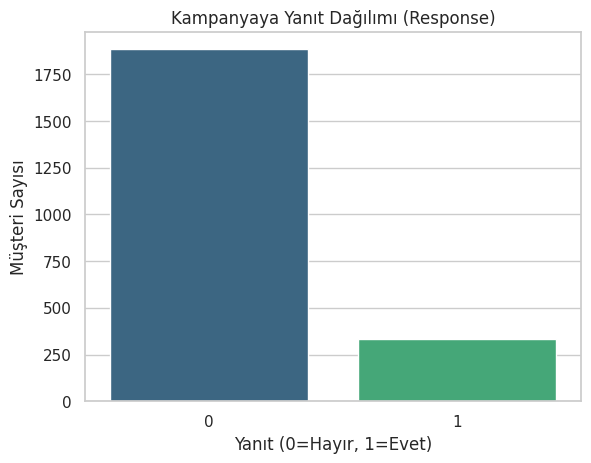

In [2]:
sns.set(style="whitegrid")

sns.countplot(x='Response', data=df, palette='viridis')
plt.title('Kampanyaya Yanıt Dağılımı (Response)')
plt.xlabel('Yanıt (0=Hayır, 1=Evet)')
plt.ylabel('Müşteri Sayısı')
plt.show()

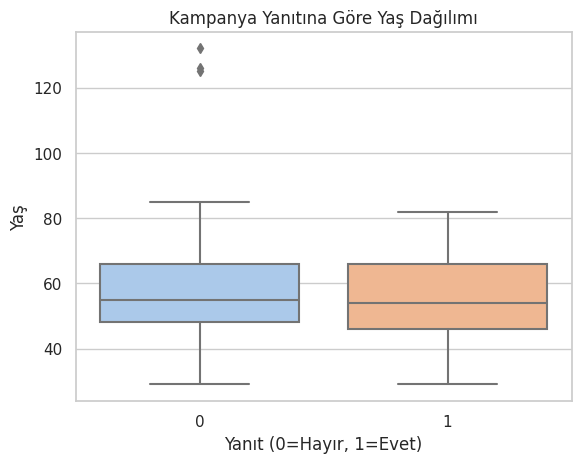

In [3]:
sns.boxplot(x='Response', y='Customer_Age', data=df, palette='pastel')
plt.title('Kampanya Yanıtına Göre Yaş Dağılımı')
plt.xlabel('Yanıt (0=Hayır, 1=Evet)')
plt.ylabel('Yaş')
plt.show()

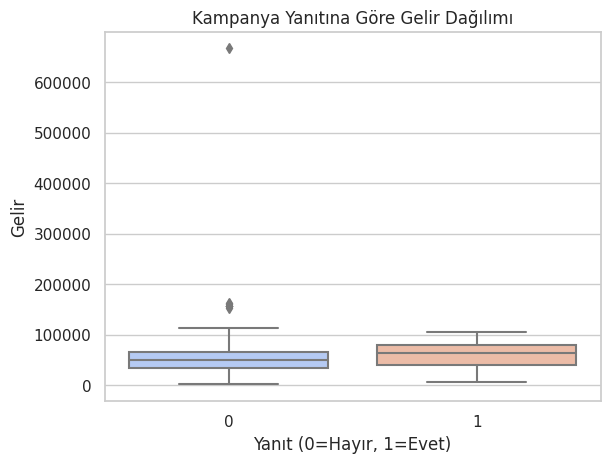

In [4]:
sns.boxplot(x='Response', y='Income', data=df, palette='coolwarm')
plt.title('Kampanya Yanıtına Göre Gelir Dağılımı')
plt.xlabel('Yanıt (0=Hayır, 1=Evet)')
plt.ylabel('Gelir')
plt.show()

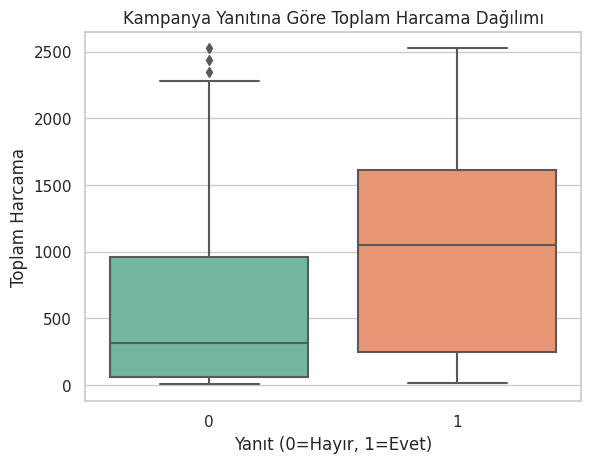

In [5]:
sns.boxplot(x='Response', y='TotalSpent', data=df, palette='Set2')
plt.title('Kampanya Yanıtına Göre Toplam Harcama Dağılımı')
plt.xlabel('Yanıt (0=Hayır, 1=Evet)')
plt.ylabel('Toplam Harcama')
plt.show()

In [6]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned = df.copy()
for col in ['Customer_Age', 'Income', 'TotalSpent']:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

print("Kalan gözlem sayısı:", df_cleaned.shape[0])

Kalan gözlem sayısı: 2202


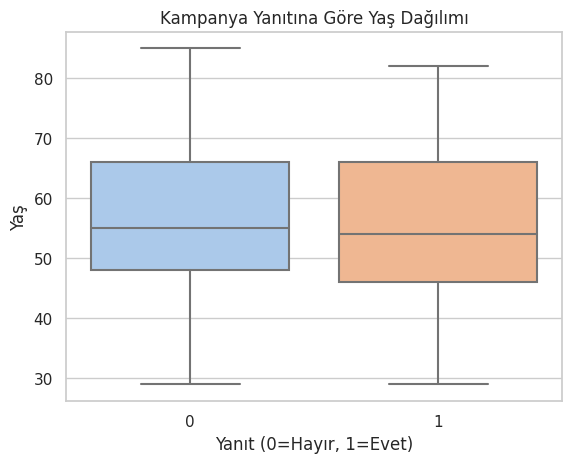

In [7]:
sns.boxplot(x='Response', y='Customer_Age', data=df_cleaned, palette='pastel')
plt.title('Kampanya Yanıtına Göre Yaş Dağılımı')
plt.xlabel('Yanıt (0=Hayır, 1=Evet)')
plt.ylabel('Yaş')
plt.show()

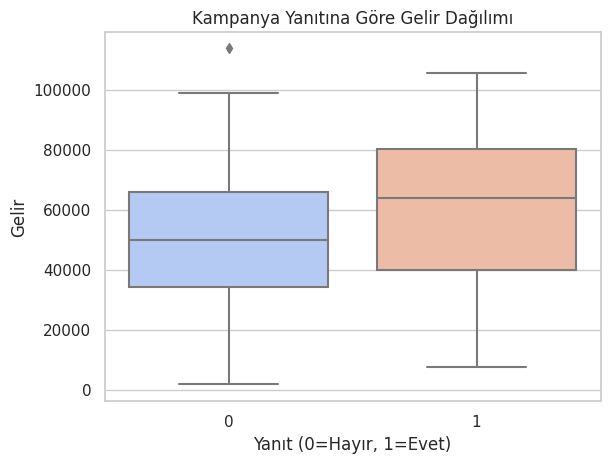

In [8]:
sns.boxplot(x='Response', y='Income', data=df_cleaned, palette='coolwarm')
plt.title('Kampanya Yanıtına Göre Gelir Dağılımı')
plt.xlabel('Yanıt (0=Hayır, 1=Evet)')
plt.ylabel('Gelir')
plt.show()

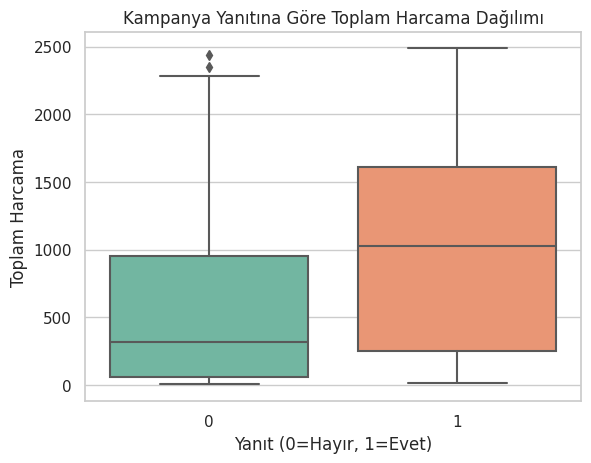

In [9]:
sns.boxplot(x='Response', y='TotalSpent', data=df_cleaned, palette='Set2')
plt.title('Kampanya Yanıtına Göre Toplam Harcama Dağılımı')
plt.xlabel('Yanıt (0=Hayır, 1=Evet)')
plt.ylabel('Toplam Harcama')
plt.show()

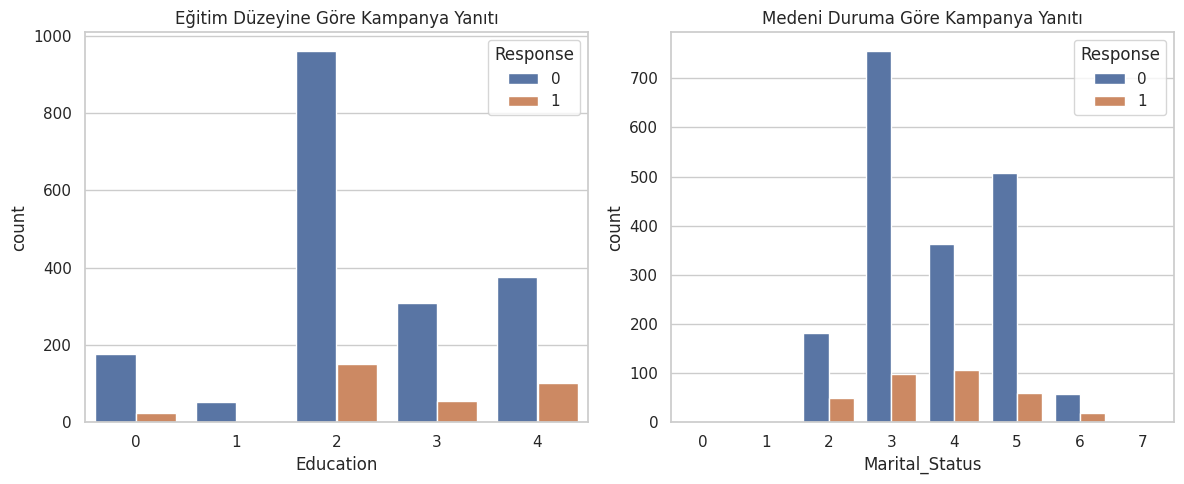

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x='Education', hue='Response', data=df_cleaned)
plt.title('Eğitim Düzeyine Göre Kampanya Yanıtı')

plt.subplot(1,2,2)
sns.countplot(x='Marital_Status', hue='Response', data=df_cleaned)
plt.title('Medeni Duruma Göre Kampanya Yanıtı')

plt.tight_layout()
plt.show()


In [11]:
from sklearn.preprocessing import MinMaxScaler

segment_features = ['Income', 'Customer_Age', 'TotalSpent', 'Customer_Since_Days']
X = df_cleaned[segment_features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

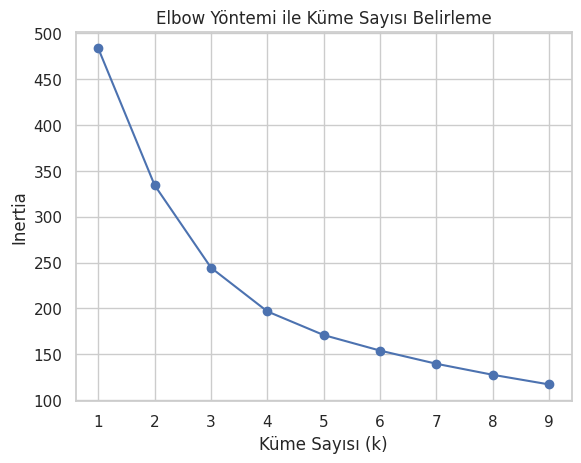

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Yöntemi ile Küme Sayısı Belirleme')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
df_cleaned['Segment'] = kmeans.fit_predict(X_scaled)

df_cleaned.groupby('Segment')[['Income', 'Customer_Age', 'TotalSpent', 'Customer_Since_Days', 'Response']].mean().round(2)


,Income,Customer_Age,TotalSpent,Customer_Since_Days,Response
Segment,,,,,
0,36179.60,53.78,208.90,4522.75,0.15
1,69962.65,58.58,1289.20,4541.22,0.28
2,39254.44,54.98,144.18,4179.41,0.05
3,73296.75,58.63,1149.67,4181.69,0.15


In [14]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=['Response'])
y = df_cleaned['Response'] 

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


              precision    recall  f1-score   support

           0       0.89      0.97      0.92       375
           1       0.61      0.29      0.39        66

    accuracy                           0.87       441
   macro avg       0.75      0.63      0.66       441
weighted avg       0.84      0.87      0.85       441



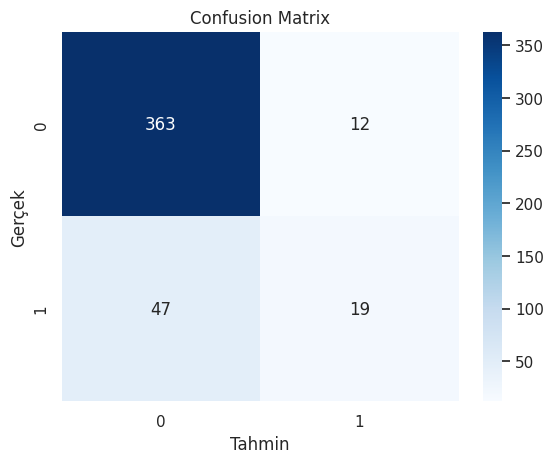

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()


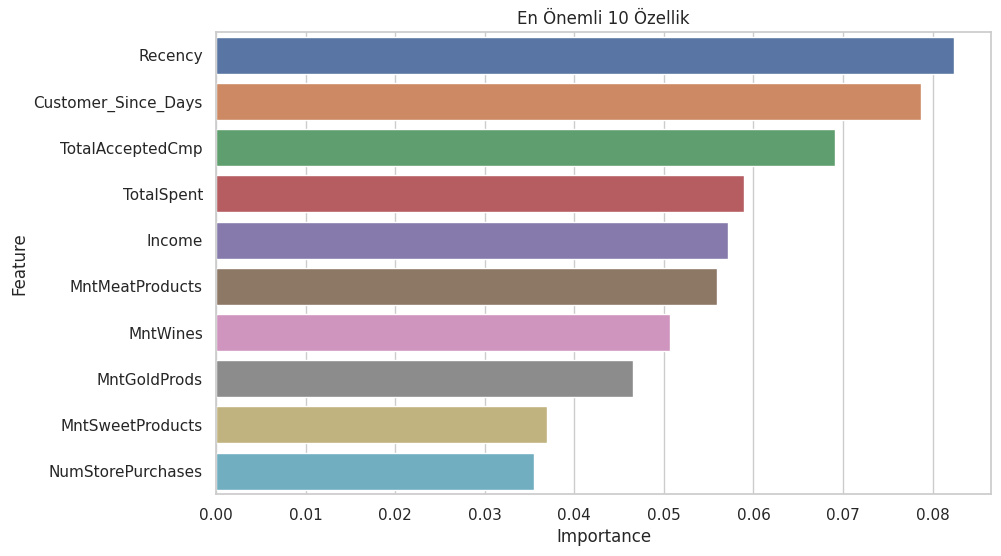

In [16]:
importances = model.feature_importances_
feat_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature')
plt.title('En Önemli 10 Özellik')
plt.show()
